In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import pandas as pd
from PIL import Image
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Data understanding and preparation

Import from data.csv, which consist the image number and corresponding label and label name as mj_df

In [2]:
mj_df = pd.read_csv("data.csv")
print('Shape of data:', mj_df.shape)
display(mj_df.head())

Shape of data: (700, 3)


,image-name,label,label-name
0,1.jpg,38,bonus-winter
1,2.jpg,26,characters-8
2,3.jpg,9,dots-9
3,4.jpg,36,bonus-summer
4,5.jpg,28,honors-east


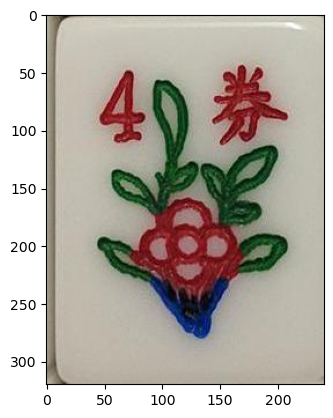

In [3]:
#Display of sample image
img0 = Image.open('images/1.jpg')
plt.imshow(img0)

In [4]:
#Adding a new column of image path to mj_df
mj_df['image-path'] = 'images/' + mj_df['image-name']
mj_df.head()

,image-name,label,label-name,image-path
0,1.jpg,38,bonus-winter,images/1.jpg
1,2.jpg,26,characters-8,images/2.jpg
2,3.jpg,9,dots-9,images/3.jpg
3,4.jpg,36,bonus-summer,images/4.jpg
4,5.jpg,28,honors-east,images/5.jpg


In [5]:
print('mj_df Label starts at: '+ str(min(mj_df['label'])))
print('Since label starts at 1, subtract 1 from labels to facilitate classification by tensorflow (dense layer output)')
mj_df['label'] -= 1
mj_df.head()
print('mj_df Label starts at: '+ str(min(mj_df['label'])) + ' after subtract.')

mj_df Label starts at: 1
Since label starts at 1, subtract 1 from labels to facilitate classification by tensorflow (dense layer output)
mj_df Label starts at: 0 after subtract.


In [6]:
# train-test split
train_index = mj_df.sample(frac=0.75,random_state = 320)# 75% train
train_size = train_index.shape[0]
val_index = mj_df.drop(train_index.index)
print('No. of entries for Train')
print(train_index.shape)
print('No. of entries for Validation')
print(val_index.shape)

No. of entries for Train
(525, 4)
No. of entries for Validation
(175, 4)


## Defining functions for reading images as tensors

In [7]:
#Define batch size, image height and width (224x224 as default dimension of MobileNet), num_classes as no. of unique classes
batch_size = 16
img_height = 224
img_width = 224
num_classes = len(np.unique(mj_df['label']))
#Later used for prefetching for better performance
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
def display_image(ds):
    for n, (image, label) in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        #image is a batch of 16 images, get the first image from the batch
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        #label is a batch of 16 one-hot encoded feature, get the first one from the batch
        plt.xlabel('Label: '+ str(np.argmax(label[0])))
    plt.show()

def read_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image_resized = tf.image.resize(image, [img_height, img_width])
    return image_resized

def get_dataset(ds_index):
    path_ds = tf.data.Dataset.from_tensor_slices(ds_index['image-path'])
    image_ds = path_ds.map(read_image)#, num_parallel_calls=AUTOTUNE)
    label_one_hot = tf.one_hot(ds_index['label'], num_classes)
    label_ds = tf.data.Dataset.from_tensor_slices(label_one_hot)
    
    paired_ds = tf.data.Dataset.zip((image_ds, label_ds))

    return paired_ds

## Get training and validation set, making them into batches

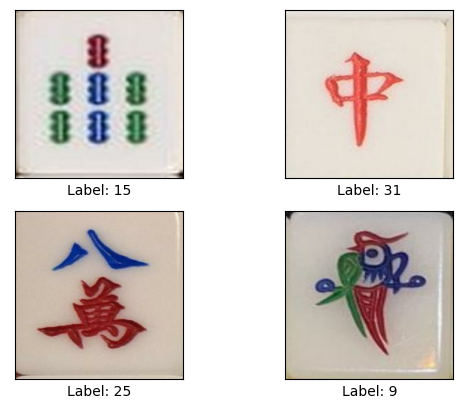

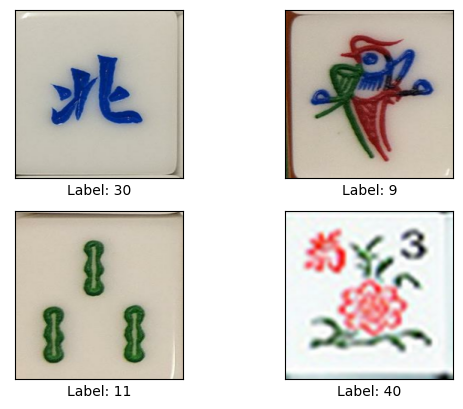

In [9]:
train_ds = get_dataset(train_index)
train_ds = train_ds.batch(batch_size)
val_ds = get_dataset(val_index)
val_ds = val_ds.batch(batch_size)

#Display of sample images in each set
display_image(train_ds)
display_image(val_ds)

In [10]:
train_ds = train_ds.cache().shuffle(train_index.shape[0]).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create base model with Mobilenet V2

In [11]:
#Specifying the include_top=False argument, so that the network doesn't include the classification layers at the top
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')


In [12]:
#Feature extractor converts each 224x224x3 image into a 7x7x1280 block of features, in a batch of 16 images
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [13]:
#Set base_model as not trainable, which prevents the weights in a given layer from being updated during training, to allow extraction of features
base_model.trainable = False

In [14]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.summary()

Number of layers in the base model:  154
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )     

## Define classification layer and input processing/ augmentation

In [15]:
#Use tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [16]:
#Convert features into a single prediction per image,with 42 classes
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 42)


In [17]:
#Define data normalization with tf.keras.applications.mobilenet_v2.preprocess_input and data augmentation
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
data_augmentation = tf.keras.Sequential([
  layers.RandomZoom(.2,.2),
  layers.RandomRotation(0.2),
  #layers.Dropout(0.2)
])

## Building model by chaining together preprocessing, augmentation, base model and feature extractor layer, then compile model

In [18]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)

print('Output has a dimension of: ' + str(outputs.shape))
model = tf.keras.Model(inputs, outputs)

Output has a dimension of: (None, 42)


In [19]:
#Compile model with Adam optimizer, Categorical Crossentropy for multiclass classification
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

## Model Training

In [20]:
#initial_epochs = 10

#loss0, accuracy0 = model.evaluate(val_ds)

In [21]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
33/33 [==============================] - 22s 541ms/step - loss: 4.0572 - accuracy: 0.0800 - val_loss: 3.0405 - val_accuracy: 0.2286
Epoch 2/50
33/33 [==============================] - 15s 466ms/step - loss: 2.7716 - accuracy: 0.2324 - val_loss: 2.5141 - val_accuracy: 0.3200
Epoch 3/50
33/33 [==============================] - 16s 478ms/step - loss: 2.1922 - accuracy: 0.3505 - val_loss: 2.2231 - val_accuracy: 0.3829
Epoch 4/50
33/33 [==============================] - 16s 475ms/step - loss: 1.8241 - accuracy: 0.4686 - val_loss: 2.0203 - val_accuracy: 0.3943
Epoch 5/50
33/33 [==============================] - 18s 559ms/step - loss: 1.5685 - accuracy: 0.5086 - val_loss: 1.8420 - val_accuracy: 0.4743
Epoch 6/50
33/33 [==============================] - 17s 523ms/step - loss: 1.4585 - accuracy: 0.5505 - val_loss: 1.8038 - val_accuracy: 0.4800
Epoch 7/50
33/33 [==============================] - 18s 540ms/step - loss: 1.2710 - accuracy: 0.6019 - val_loss: 1.6314 - val_accuracy: 0.5143

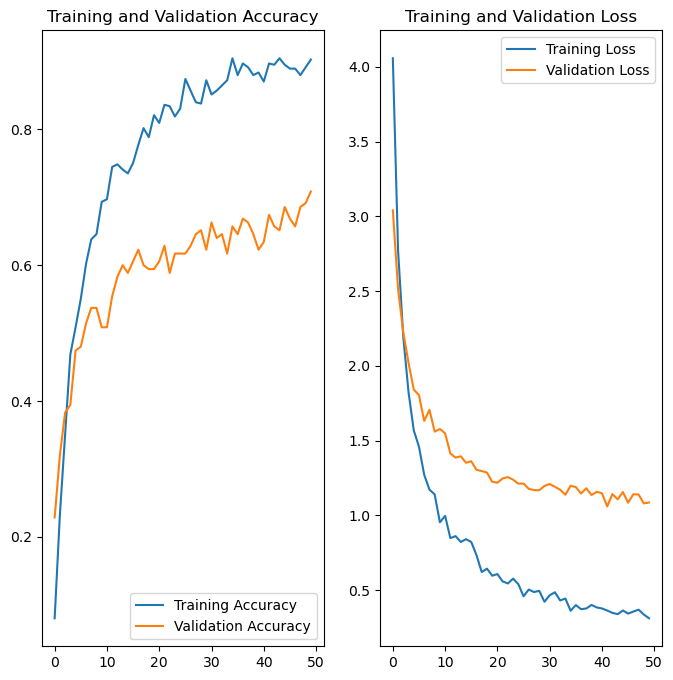

In [22]:
#Visualizing the learning curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Generating classification report

In [23]:
from sklearn.metrics import classification_report

#Predict y_pred with model
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)
unique_class = np.unique(y_pred)
print('No. of unique class predicted: ' + str(len(unique_class)))
print('y_pred:\n', y_pred)
#Verify against y_true in val_ds
y_true = np.concatenate([y for (x, y) in val_ds], axis=0)
print('y_true:\n', np.argmax(y_true, axis = 1))
cr = classification_report(np.argmax(y_true, axis=1), y_pred, output_dict=True)#, target_names=np.argmax(y_true, axis = 1)

11/11 [==============================] - 6s 374ms/step
No. of unique class predicted: 41
y_pred:
 [30 29 22  2 11 23 21 18  6 30 23  1  3 29 14 12  9  4 30 20  4 33  0 13
 17 28  0 26  8 32  1  7 11 10 23 30 28 17 14  7  4  2 22 20 20  3  7  0
 40 33 31  0 25  3  7 14 27 30 26  0  5 37 37 34 37 28  5 13 13 18 16 10
  9 40 31 23  8  6  6  1 30 37 27 21  7 24  5 11 11 10  9 36 35 33 15 22
 13 21 20 18 18  6  8 35  0 28 29  3 37 23 22 22 14 38 36 33 29 17  5 23
  0 40 33 22 23 17 13 22 11 40 37 41 38 33 16  7  5  4 23 23  9 37 33 25
  8 24 14 13  3 21 18 39 37 35 28 30 32 33 18 20 23 26  2  3  4  5  7 11
 14 13 17 37 37 32 30]
y_true:
 [30 29 22  2 11 24 21 18  6 30 23  1  3 29 12 12  9  4 30 20  4 33  0 13
 17 28  0 26  8 32  1 25 11 10 32 30 28 17 14  7  6  2 22 20 19  3  7  0
 40 33 31  1 25  2  7 12 27 11 26  0  6 37 35 34 35 28  5 13 11 19 16 10
  9 38 31 23  8  5  4  2 30 37 27 25  7 24  6 12 11 10  9 36 35 33 15 22
 13 21 20 19 18  5  8 36  0 28 29  3 40 23 19 20 12 38 35 33 29 17 

C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
result = pd.DataFrame.from_dict(cr).T
display(result)

,precision,recall,f1-score,support
0,0.857143,1.000000,0.923077,6.000000
1,0.666667,0.666667,0.666667,3.000000
2,1.000000,0.600000,0.750000,5.000000
3,0.666667,1.000000,0.800000,4.000000
4,0.800000,0.666667,0.727273,6.000000
5,0.333333,0.500000,0.400000,4.000000
6,0.250000,0.166667,0.200000,6.000000
7,0.857143,0.857143,0.857143,7.000000
8,0.750000,1.000000,0.857143,3.000000
9,1.000000,0.800000,0.888889,5.000000


## Model fine-tuning

In [25]:
#Set model to trainable, and check the number of layers in base model
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 90

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [26]:
#Training
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [27]:
fine_tune_epochs = 30
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 50/80
33/33 [==============================] - 39s 876ms/step - loss: 0.3334 - accuracy: 0.8838 - val_loss: 1.1021 - val_accuracy: 0.7200
Epoch 51/80
33/33 [==============================] - 27s 813ms/step - loss: 0.2875 - accuracy: 0.9105 - val_loss: 1.0755 - val_accuracy: 0.6971
Epoch 52/80
33/33 [==============================] - 27s 828ms/step - loss: 0.2396 - accuracy: 0.9219 - val_loss: 1.1318 - val_accuracy: 0.6971
Epoch 53/80
33/33 [==============================] - 25s 750ms/step - loss: 0.2606 - accuracy: 0.9181 - val_loss: 1.0139 - val_accuracy: 0.7314
Epoch 54/80
33/33 [==============================] - 27s 811ms/step - loss: 0.2617 - accuracy: 0.9181 - val_loss: 1.0530 - val_accuracy: 0.7029
Epoch 55/80
33/33 [==============================] - 29s 894ms/step - loss: 0.2043 - accuracy: 0.9410 - val_loss: 1.0365 - val_accuracy: 0.7086
Epoch 56/80
33/33 [==============================] - 25s 752ms/step - loss: 0.1743 - accuracy: 0.9467 - val_loss: 0.9716 - val_accuracy:

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

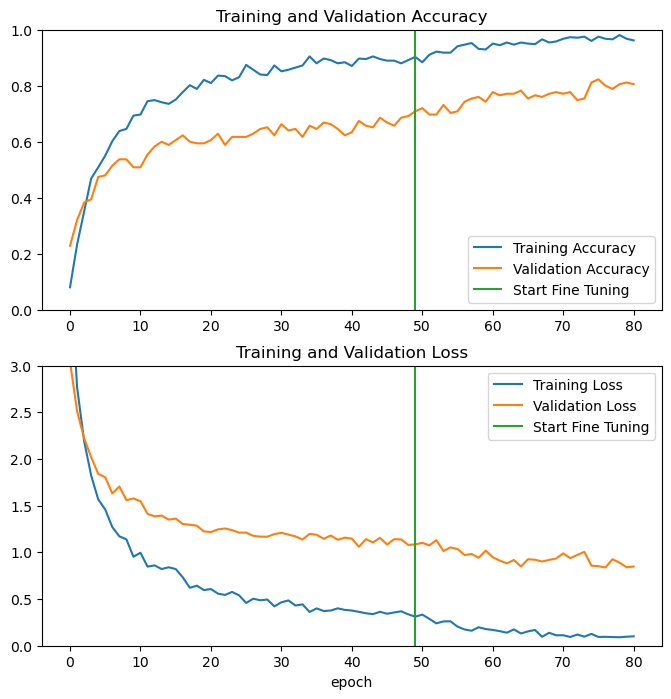

In [29]:
#Learning curve of model training + fine tuning
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
y_pred_fine = model.predict(val_ds)
y_pred_fine = np.argmax(y_pred_fine, axis=1)
cr_fine = classification_report(np.argmax(y_true, axis=1), y_pred_fine, output_dict=True)
report_fine = pd.DataFrame.from_dict(cr_fine).T
display(report_fine)

11/11 [==============================] - 6s 316ms/step


,precision,recall,f1-score,support
0,0.857143,1.000000,0.923077,6.000000
1,1.000000,0.666667,0.800000,3.000000
2,1.000000,0.600000,0.750000,5.000000
3,0.800000,1.000000,0.888889,4.000000
4,1.000000,0.833333,0.909091,6.000000
5,0.200000,0.250000,0.222222,4.000000
6,0.333333,0.333333,0.333333,6.000000
7,0.875000,1.000000,0.933333,7.000000
8,0.750000,1.000000,0.857143,3.000000
9,1.000000,0.600000,0.750000,5.000000


__Fine tuning from layer 90 onwards with 20 epoch has improved the val accuracy from ~0.7 to ~0.8.__

## Display of true and predicted class examples

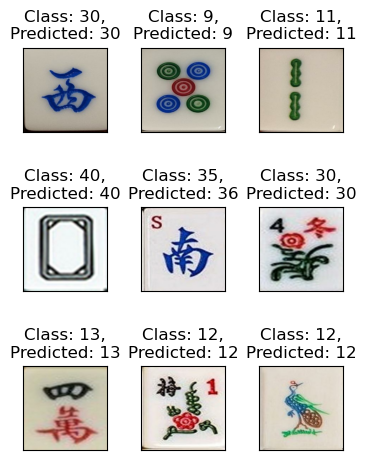

In [31]:
for n, (image, label) in enumerate(val_ds.take(9)):
    plt.subplot(3,3,n+1)
    plt.imshow(image[1].numpy().astype("uint8"))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.6,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
    plt.title("Class: {},\nPredicted: {}".format(np.argmax(label), y_pred_fine[n*batch_size]))
plt.show()


## Conclusion

The fine tuned Mobilenet_V2 model demonstrated its ability to classify mahjong class, with accuracy of ~0.8 on validation set. The image dataset has a relatively small size of 700 images and 42 classes, which could lead to insufficient data for training, even with data augmentation. Overfitting was encoutnered in the earlier stage of development, as the 154 layers Mobilenet_V2 was trained to a small set of data. The model accuracy on validation set has improved significantly after dropout was introduced.